In [1]:
# because of version problems,
# Jupyter notebook prints too many warning messsage
# This parts helps to ignore these warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%pwd

'/home/qiao/dev/giao/havingfun/detecting/segmentation/unet34'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
path = Path('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/')

path_img = path/'S_kaggle_wildfire/'
path_label = path/'S_kaggle_wildfire_label/'
# codes = ['Smoke', 'Flame', 'Cloud', 'Background']
codes = ['Smoke', 'Flame', 'Background']
path_img

Path('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire')

### To check whether loaded the data correctly

In [6]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/000366.jpg


In [7]:
fnames = get_image_files(path_img)
print(fnames[0])
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/000366.jpg
/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire_label/label_000373.jpg


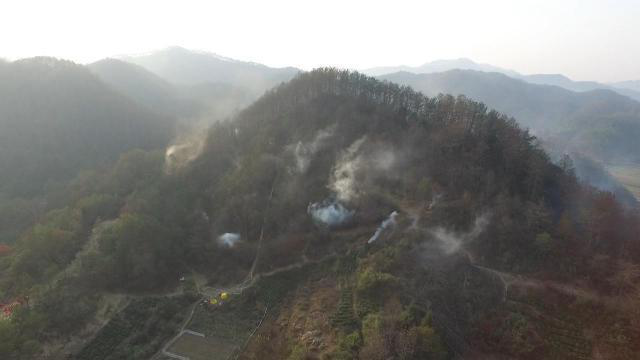

In [8]:
img = Image.open(fnames[0])
img.show()

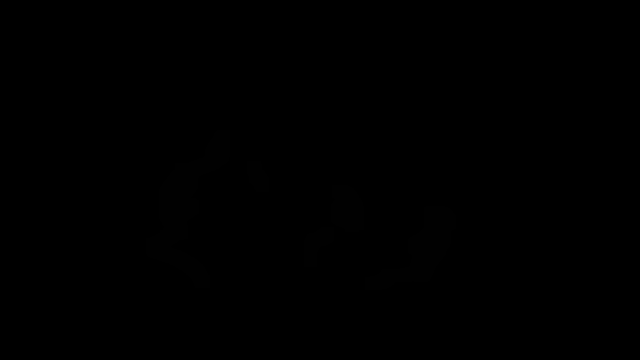

In [9]:
img = Image.open(lbl_names[0])
img.show()

### To bound the labels and original images

In [10]:
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

### To build the data loaders for feeding in the model
Considering the registion problem, the `resize` need to be carefully defined:  
    In this work, the original image size from H20T is 960x720.  
    Therefore, the images are resized into 480x385, which is half of original size.  
    It need to be noted that, for the `Resize` func for PILImage, the resize order is Height --> Wide.

In [11]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 4,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((385, 480))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [12]:
dls

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

For fastai, the original evaluation is an _accuracy function_
```python
def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke
```

2022-07-10  
Trying to modify the evaluation matrix from `acc_smoke` into `F1-score` or `average precision`
`sciki-learn` is going to be aplied for that evaluations  
* F1-score
```python
import numpy as np
from sklearn,metrics import f1_score
actual = np.repeat([1, 0], repeats = [160, 240])
pred = np.repeat([1, 0, 1, 0], repreats = [120, 40, 70, 170])
f1_score(actual, pred)
```

* Average Precison (AP)
```python
import numpy as np
from sklearn.matrics import average_precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
average_precision_score(y_true, y_scores)
```

In [13]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']
# metrics = acc_smoke

2022-07-11  
Edited the evaluation metrics  
so that it could be compared:  
* pixel-level accuracy
* f1-score: (2 * (precision * recall) / (precision + recall))
* average precision score $$AP = \sum_n (R_n - R_{n-1})P_n$$ where $P_n$ and $R_n$ are the precision and recall at the $n_{th}$ threshold. It means the area under the precision-recall curve
* ROC_AUC_score: Area under the receiver operating characteristic curve (ROC AUC) from prediction scores. (True positve, false positive curve).

$\text{Precision} = {TP\over (TP + FP)}$  
$\text{Recall} = {TP\over (TP + FN)}$

| \ | True| False|
|---| ---| ---|
| __Positive__| TP| FP|
| __Negative__| TN| FN|

In [14]:
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# original, pixel level accuracy
def pixel_accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

# auc: area under the curve, a general computing using the trapezoidal rule.
# roc_curve: Receiver operating characteristic (ROC); xlabel: false positve; ylabel: true positive
# roc_auc_score: area under the receiver operating characteristic curve
def auc_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    Auc_score = roc_auc_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), multi_class='ovr')
    return Auc_score

# f1-score
def f1_score_macro(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    F1 = f1_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu(), average = 'macro') # , average = 'macro'
    return F1

# average precision score: area under the precision-recal curve
def precision_score(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # for multilabel-indicator, `pos_label` is fixed to 1.
    precision_score = average_precision_score(target[mask].cpu(), input.argmax(dim = 1)[mask].cpu())
    return precision_score

# metrics = evaluate_acc
metrics = [pixel_accuracy, auc_score, f1_score_macro, precision_score]
# metrics = roc_curve
# metrics = evaluate_ap

In [15]:
learn = unet_learner(dls, models.resnet34, metrics = metrics, self_attention=False)

In [16]:
# learn.callbacks.append(callback_fns(learn))

In [17]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(valley=4.365158383734524e-05)

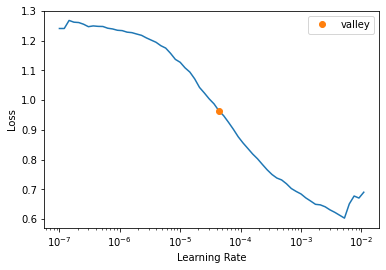

In [18]:
# finding appropriate learning rate
# learn.lr_find(stop_div=False, num_it=20)
learn.lr_find()

In [19]:
lr = 4.36e-5
learn.fit_one_cycle(16, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,f1_score_macro,precision_score,time
0,0.459061,0.332150,0.870604,0.501000,0.311477,0.130360,01:37
1,0.191671,0.148314,0.945646,0.841910,0.575044,0.619163,01:35
2,0.144568,0.124672,0.951116,0.886465,0.684579,0.664811,01:35
3,0.130925,0.119828,0.952542,0.850580,0.594138,0.655960,01:35
4,0.102843,0.117494,0.952172,0.827947,0.589154,0.650107,01:35
5,0.113673,0.101615,0.959099,0.907512,0.612951,0.715923,01:35
6,0.103171,0.101459,0.958458,0.924966,0.605083,0.719760,01:35
7,0.093596,0.092546,0.962279,0.917183,0.608468,0.735867,01:35
8,0.082213,0.098629,0.960773,0.874406,0.619553,0.715923,01:35
9,0.081373,0.089052,0.963245,0.913991,0.610095,0.741111,01:35


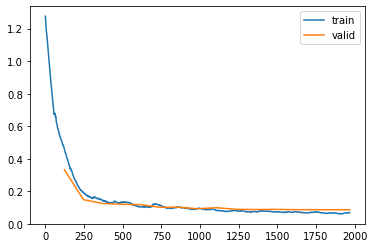

In [20]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [21]:
learn.save('u34freeze_ori_step1_20220711')
learn.load('u34freeze_ori_step1_20220711')

SuggestedLRs(valley=8.31763736641733e-06)

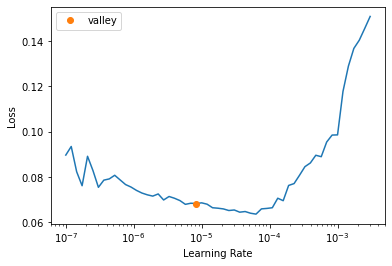

In [22]:
learn.unfreeze()
learn.lr_find()

In [24]:
lr_max = 8.31e-6

In [25]:
learn.fit_one_cycle(17, lr_max)

epoch,train_loss,valid_loss,pixel_accuracy,auc_score,f1_score_macro,precision_score,time
0,0.070231,0.085586,0.965183,0.906189,0.630565,0.751171,01:40
1,0.062823,0.085443,0.965082,0.902302,0.629902,0.750325,01:40
2,0.063502,0.087596,0.964359,0.904846,0.629748,0.746963,01:40
3,0.069382,0.082546,0.966078,0.927394,0.624597,0.760624,01:40
4,0.065816,0.084922,0.965913,0.909151,0.641352,0.755540,01:40
5,0.062134,0.083144,0.966416,0.906340,0.622699,0.759854,01:40
6,0.059489,0.081248,0.966458,0.909443,0.623267,0.759926,01:40
7,0.058554,0.082458,0.966726,0.924073,0.625281,0.764377,01:40
8,0.054467,0.081205,0.967166,0.924019,0.626210,0.768698,01:40
9,0.052903,0.083219,0.967123,0.911986,0.634094,0.764323,01:40


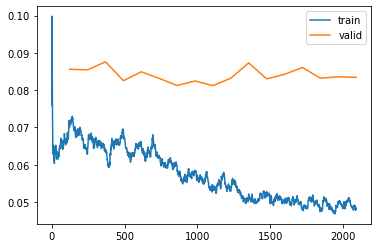

In [26]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/datasets/M300bounding/Step1_training/S_kaggle_wildfire/models/u34unfreeze_ori_step1_20220711.pth')

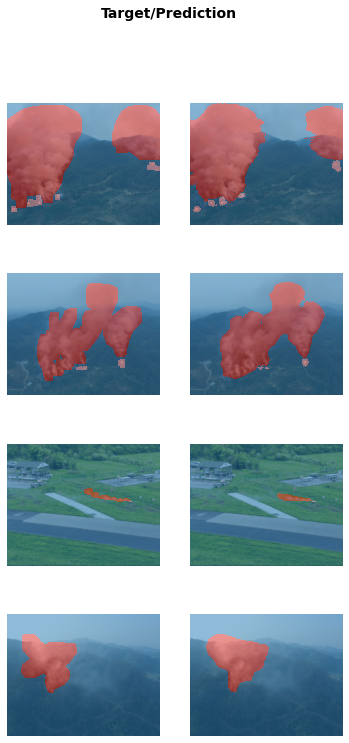

In [27]:
learn.show_results()
learn.save('u34unfreeze_ori_step1_20220711')

In [ ]:
# one time test on untrained distance
import cv2
import numpy as np
from PIL import Image

img = cv2.imread('/home/qiao/dev/giao/datasets/orignial/m300_grabbed_data_1_31.6//rgb/127.png')
# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img).resize((385, 400))
im_pil.show()
print(im_pil)

In [ ]:
learn.load('u34unfreeze_ori_step1_20220711')
# learn.load('attunet')

In [ ]:
# pilimg = PILImage(im_pil)
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

The result for the 31.6m dataset does not work well, which means it is needed to train the model more to cover all distance datasets.
__Therefore, going to 'original U34 traning step2'__

In [ ]:
##########################################
#  Test part  ############################
##########################################

In [ ]:
# testing dependencies
import os
import cv2

from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = Path('/home/qiao/dev/giao/datasets/')

path_img = path/'S_kaggle_wildfire/'
path_label = path/'S_kaggle_wildfire_label/'
codes = ['Smoke', 'Flame', 'Cloud','Background']
path_img

In [ ]:
# still loading the traning dls (dataloaders)
fnames = get_image_files(path_img)
print(fnames[0])
lbl_names = get_image_files(path_label)
print(lbl_names[0])

In [ ]:
# connections between images and masks
get_y_fn = lambda x: path_label/f'label_{x.name}'
defaults.use_cuda = True

dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 1,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [ ]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [ ]:
# model information
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

device = 'cuda'
learn.model.to(device)

In [ ]:
# load the trained parameters into the model
learn.load('/home/qiao/dev/giao/datasets/models/models20220520/20220516_attunet_res34')

In [ ]:
# get the test image folder
test_path = '/home/qiao/dev/giao/datasets/bounding/images'
test_fnames = get_image_files(test_path)

# test whether successfully loaded
print(f'======> example name: {test_fnames[0]}')

In [ ]:
# test of one_time prediction example
pilimg = Image.open(test_fnames[0]).resize((960, 770))
print(pilimg)
test_img = PILImage(pilimg)
print(test_img)
print(test_fnames[0].name)

test_pred_all = learn.predict(test_img)
test_pred = test_pred_all[0]
plt.imshow(test_pred)
# test_pred.resize((960, 770))
# test_pred = Image.fromarray(test_pred).resize((960, 770))
# plt.imshow(test_pred)
plt.savefig(f'predmask_{test_fnames[0].name}')

In [ ]:
print(torch.min(test_pred))

In [ ]:
# transform and convert
test_pred_torch = test_pred # torch.int64
test_pred_int64 = test_pred_torch.numpy()*255/2# torch.int64 --> np.int64 # *255
test_pred_float64 = np.asarray(test_pred_int64, dtype = np.float64,  # np.int64 --> np.float64 # np.uin64
                        order ='C')

test_pred_pil = Image.fromarray(test_pred_float64).resize((960, 770)).convert("RGB")
test_pred_pil.show()
print(test_pred.dtype)
print(test_pred_float64.dtype)
print(test_pred_pil)

In [ ]:
# to know how many images are going to be predicted
total_number = len(test_fnames)
print(f'======> There are totally {total_number} images going to be predicted.')    

In [ ]:
# get the testing time
from datetime import datetime

now = datetime.now()
date_time = now.strftime('%Y%m%d%H%M') # Y for year, m for month, d for day, H for hour, M for minute, S for second
print(f'======> The time: {date_time}')

In [ ]:
# build the folder to store predicted masks
import os
import pathlib

test_pred_path = pathlib.Path(f"/home/qiao/dev/giao/datasets/bounding/pred_{date_time}" )
test_pred_path.mkdir(parents=True, exist_ok=True)

print(f'======> created the folder: {test_pred_path}')

In [ ]:
# save resized mask to particular folder
test_pred_pil.save(f'{test_pred_path}/predmask_{test_fnames[0].name}', 'PNG')

In [ ]:
# process the images one by one with a 'for loop'
from tqdm import tqdm

# for count
i = 0
for test_fname in test_fnames:
    # load
    test_pilimgimg = Image.open(test_fname).resize((960, 770))
    test_pilimg = PILImage(test_pilimgimg)

    # predict
    test_pred_torch_all = learn.predict(test_pilimg)
    test_pred_torch= test_pred_torch_all[0]

    # convert
    test_pred_int64 = test_pred_torch.numpy() * 255/2 # torch.int64 --> np.int64
    test_pred_float64 = np.asarray(test_pred_int64, dtype = np.float64, order ='C') # np.int64 --> np.float64
    test_pred_pil = Image.fromarray(test_pred_float64).resize((960, 770)).convert('RGB')

    # save
    test_pred_pil.save(f'{test_pred_path}/predmask_{test_fname.name}', 'PNG')
    
    # count
    count = []
    i += 1
    count.append(i)
    print(f'======> No.{count} predicted mask saved!')

print('\n======> Mission accomplished!!!')